In [9]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

First step of the proposed algorithm is to list the edges of the underlying raster.

In [32]:
dem_path = '../data_nongit/flow_dir_test_grid_cell_1.tif'
dem_rast = rasterio.open(dem_path)

# Reading as numpy raster and removing no-data edges
dem_np = dem_rast.read(1)[0:-1, 1:]

# mapping direction values from D8 to VIC standard
dem_vic = np.copy(dem_np)
flow_map = {1:3, 2:4, 4:5, 8:6, 16:7, 32:8, 64:1, 128:2}
for k in flow_map.keys(): 
    dem_vic[dem_np==k] = flow_map[k]
dem_vic

array([[1, 8, 2, ..., 6, 5, 5],
       [8, 2, 3, ..., 5, 5, 5],
       [4, 4, 5, ..., 5, 5, 5],
       ...,
       [2, 1, 8, ..., 6, 5, 5],
       [1, 8, 8, ..., 6, 6, 6],
       [8, 8, 1, ..., 6, 5, 6]], dtype=uint8)

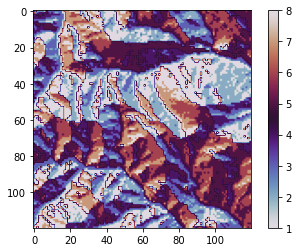

In [40]:
plt.imshow(dem_vic, cmap='twilight')
plt.colorbar()

In [48]:
# find the indices of the pixels that point outwards
# for left edge: 8, 7, 6
left_pour = [(0, y) for y in np.where(dem_vic[:, 0] == 8)[0]]  # indices of pixels in left edge that flow outwards
left_pour

# TODO Similarly for other edges - simplify and automate the process

[(0, 1),
 (0, 19),
 (0, 24),
 (0, 25),
 (0, 27),
 (0, 28),
 (0, 57),
 (0, 58),
 (0, 65),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 119)]

The **second** step is to loop over all the outward flowing pixels, and count the *weight* of that pixel, where the *weight* is defined as the number of pixels contributing to the watershed of 

In [209]:
# def look_around(index):
#     x, y = index
#     return [(x-1, y),
#             (x, y-1),
#             (x-1, y-1),
#             (x+1, y),
#             (x, y+1),
#             (x+1, y+1),
#             (x-1, y+1),
#             (x+1, y-1)]

def flows_in(index, x_max, y_max):
    x, y = index
    who_flows = np.array((2, 3, 4, 1, 0, 5, 8, 7, 6))
    who_flows_human = ('NE', 'E', 'SE', 'N', 'Nothing', 'S', 'NW', 'W', 'SW')
    
    neighbours = np.zeros_like([who_flows, who_flows])
    # neighbours_y = np.zeros_like(who_flows)
    
    i = 0
#     print(x_max, y_max)
    for x_mod in (-1, 0, 1):
        for y_mod in (-1, 0, 1):
            # neighbours.append((x+x_mod, y+y_mod))
            # print(f"{who_flows[i]} ({who_flows_human[i]}) flows from ({x + x_mod}, {y + y_mod})")
            if (x+x_mod < 0) or (y+y_mod < 0):
                neighbours[0, i] = -1
                neighbours[1, i] = -1
            elif (x+x_mod >= x_max) or (y+y_mod >= y_max):
                neighbours[0, i] = -1
                neighbours[0, i] = -1
            else:
                neighbours[0, i] = x + x_mod
                neighbours[1, i] = y + y_mod
            i += 1
    return neighbours.T, who_flows

# flows_in((0, 10))

In [210]:
neighbours, what_to_look_for = flows_in((0, 19))

TypeError: flows_in() missing 2 required positional arguments: 'x_max' and 'y_max'

In [211]:
neighbours

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       [ 0, 18],
       [ 0, 19],
       [ 0, 20],
       [ 1, 18],
       [ 1, 19],
       [ 1, 20]])

In [212]:


def create_watershed(index, maximum):
    index = tuple(index)
    x_max, y_max = maximum
#     print(f"Index: {index}")
    neighbours, what_to_look_for = flows_in(index, x_max, y_max)
    
    nodata = np.array([-1, -1])
    matches = np.zeros_like(what_to_look_for)

    who_flows = []

    for index, neighbour in enumerate(neighbours):
        if (neighbour != nodata).any():
            if dem_vic[neighbour[0], neighbour[1]] == what_to_look_for[index]:
                who_flows.append(neighbour)
    
    # If number of flowing cells is more than 0, look at those cells, and see how many other cells flow into them (classic recursion)
    if len(who_flows) > 0:
        for flower in who_flows:
            who_flows.extend(create_watershed(flower, maximum))
    
    return who_flows 
#     if len(who_flows) > 0:
#         return who_flows#.append([create_watershed(they_flow_into_me) for they_flow_into_me in who_flows])
#     else:
#         return []
#     return [create_watershed(index) for index in who_flows if len(who_flows) != 0]

In [213]:
indices = np.array(create_watershed((0, 24), dem_vic.shape)).T


In [214]:
# create_watershed((0, 0))
indices

array([[ 1,  2,  3,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,
         6,  7,  7,  7,  6,  7,  7,  7,  7,  4,  5,  6,  7,  7,  6,  7,
         7,  7,  5,  6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  5,
         6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,
         7,  7,  3,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,
         6,  7,  7,  7,  6,  7,  7,  7,  7,  4,  5,  6,  7,  7,  6,  7,
         7,  7,  5,  6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  5,
         6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,
         7,  7,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,  6,
         7,  7,  7,  6,  7,  7,  7,  7,  5,  6,  7,  7,  6,  7,  7,  7,
         6,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  5,  6,  7,  7,  6,
         7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  6,  7,
         7,  7,  7,  7,  7],
       [23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 24, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25,

In [215]:
create_watershed((1, 0))

TypeError: create_watershed() missing 1 required positional argument: 'maximum'

In [216]:
indices

array([[ 1,  2,  3,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,
         6,  7,  7,  7,  6,  7,  7,  7,  7,  4,  5,  6,  7,  7,  6,  7,
         7,  7,  5,  6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  5,
         6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,
         7,  7,  3,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,
         6,  7,  7,  7,  6,  7,  7,  7,  7,  4,  5,  6,  7,  7,  6,  7,
         7,  7,  5,  6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  5,
         6,  7,  7,  6,  7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,
         7,  7,  4,  5,  6,  7,  7,  6,  7,  7,  7,  5,  6,  7,  7,  6,
         7,  7,  7,  6,  7,  7,  7,  7,  5,  6,  7,  7,  6,  7,  7,  7,
         6,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  5,  6,  7,  7,  6,
         7,  7,  7,  6,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  6,  7,
         7,  7,  7,  7,  7],
       [23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 24, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25,

In [217]:
sub_watershed = np.zeros_like(dem_vic)
sub_watershed

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [221]:
#[(0, 1),
#  (0, 19),
#  (0, 24),
#  (0, 25),
#  (0, 27),
#  (0, 28),
#  (0, 57),
#  (0, 58),
#  (0, 65),
#  (0, 97),
#  (0, 98),
#  (0, 99),
#  (0, 119)]

indices = np.array(create_watershed((0, 25), dem_vic.shape)).T
sub_watershed = np.zeros_like(dem_vic)

sub_watershed[indices[0], indices[1]] = 1
plt.imshow(sub_watershed)
# print(dem_vic.shape)

KeyboardInterrupt: 